In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [2]:
# for this notebook we also need the PyMySQL module
# uncomment this if you are working with colab notebooks
#!pip3 install PyMySQL

In [3]:
# notebook level imports
import pandas
import dsutils  # DBCredentials, execute_query, elbow_plot
from sklearn import cluster  # KMeans


In [4]:
# our database credentials
credentials = dsutils.DBCredentials(
   host = 'testdb.cwy05wfzuxbv.us-east-1.rds.amazonaws.com',
   userdb = 'world',
   user = 'csc310',
   password = 'csc310$is$fun')

Just for reference, the schema of our world database looks as follows:

<img src="https://static.packt-cdn.com/products/9781788390415/graphics/cac1f609-1c45-46d7-b066-d9481ceddf18.png">


<hr>

**Question**: Cluster the cities in the DB according to their populations.
1. How many clusters are there?
2. What is the average population of the cities in each of the clusters?

<hr>

First, how many cities are there in our DB?

In [5]:
# how many cities are in our DB?
sql_string = \
'''
SELECT
    COUNT(*) as NumberOfCities
FROM
    city
'''

In [6]:
data = dsutils.execute_query(credentials, sql_string)
data

,NumberOfCities
0,4079


We have too many cities to cluster.  We'll take a **random sample** of 1000 cities and return the population size of each of the cities in the sample.

**NOTE**: As is usual with DB servers, we want to have the server perform as much of the work as possible.

In [7]:
sql_string = \
'''
SELECT
    population as CityPopulation
FROM
    city
ORDER
    BY RAND(1)
LIMIT
    1000
'''

In [8]:
data = dsutils.execute_query(credentials, sql_string)
data

,CityPopulation
0,181804
1,247000
2,105380
3,117258
4,102985
...,...
995,106632
996,627500
997,621742
998,114733


Let's try to answer the first question and figure out how many clusters there are.

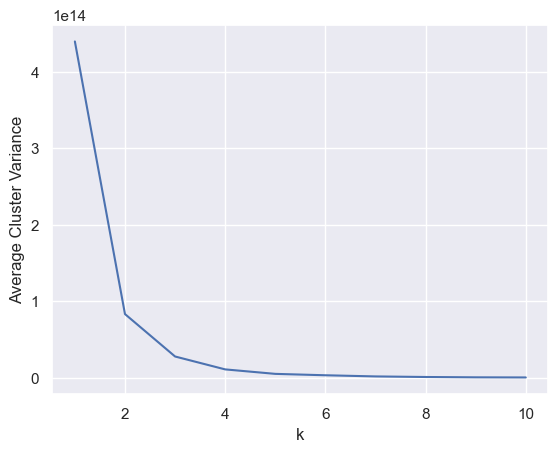

In [9]:
dsutils.plot_elbow(data)

It is clear from the plot that either k=4 or k=5 represents the optimal number of clusters.

We will pick k=4.

In [10]:
model = cluster.KMeans(n_clusters=4, random_state=1) \
               .fit(data)

# create a nice table of the cluster centroids
centers = pandas.DataFrame(model.cluster_centers_, columns=data.columns)\
                .sort_values(by='CityPopulation', ascending=False)\
                .apply(lambda x:round(x))\
                .reset_index(inplace=False)\
                .drop(columns=['index'])
centers

,CityPopulation
0,9625442.0
1,5328137.0
2,1572865.0
3,223839.0


<hr>

**Answer**:
We can answer the question above. There are four clusters when looking at population of cities with the population of each cluster as follows,

* Cluster 0  represents mega-cities with an average population of 9mil.
* Cluster 1 represents smaller metropolitan areas with an average population of 5mil.
* Cluster 2 represents cities with an average population of about 1.5mil.
* Cluster 3 represents smaller cities with an average population of about 200,000.

<hr>